In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import openpyxl
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble

plt.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.pipeline import Pipeline

# Feature Extractors
from sklearn.feature_extraction.text import CountVectorizer
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=1.0, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
rf = ensemble.RandomForestRegressor(
    oob_score = True,
    random_state =0
)
from sklearn import linear_model
log = linear_model.LogisticRegression()
#Decision Tree Pipeline
pipeline = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('log', log)
    ])

In general, we are most interested in a classifier that positively labels as many true positives as possible. 
This is equivalent to maximizing the Positive label recall, so define that scoring function

In [4]:
from sklearn.metrics import make_scorer

def my_roc_auc(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    return metrics.roc_auc_score(ground_truth, predictions, average='micro')

## We didn't actually us this in the end
''' def ms_error(ground_truth, predictions):
    ## Calculate rmse for reviews that have real label of 'yes'
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    real_yes = ground_truth[np.where(ground_truth == 1)]
    pred_for_yes = predictions[np.where(ground_truth == 1)] ## predicted value for 'yes' reviews'
    y_error = metrics.mean_squared_error(real_yes, pred_for_yes) **.5 ## rmse for 'yes' reviews
    
    ## Calculate rmse for reviews that have real label of 'yes'
    real_no = ground_truth[np.where(ground_truth == 0)]
    pred_for_no = predictions[np.where(ground_truth == 0)] ## predicted value for 'no' reviews
    n_error = metrics.mean_squared_error(real_no, pred_for_no) **.5 ## rmse for 'no' reviews
    
    print y_error
    print n_error
    ## F2 score, weighted to favor y_error
    ##error = ( (2**2 + 1) * y_error * n_error) / (y_error + (2**2) * n_error) 
    error = (2.0/3.0) * y_error + (1.0/3.0) * n_error
    return error'''
    #return metrics.mean_squared_error(ground_truth, predictions)

## Didn't use this either   
''' def pos_recall(ground_truth, predictions, pos_label='yes'):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_preds = predictions[np.where(ground_truth == pos_label)]
    true_pos = ground_truth[np.where(ground_truth == pos_label)]
    return float(len(true_preds[np.where(true_preds == true_pos)]))/len(true_pos)'''

##ms_error_scorer = make_scorer(ms_error, greater_is_better=True)
##pos_recall_scorer = make_scorer(pos_recall, greater_is_better=True)
my_roc_auc_scorer = make_scorer(my_roc_auc, needs_threshold=True, greater_is_better=True)

### Here are two functions to generate plots

In [5]:
def plot_histo(values, nbins=50, xlabel="Value", ylabel="Frequency", title="Histogram"):
    plt.hist(values, nbins, color='cadetblue')
    plt.title(title)     
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### These three functions split up the basic initial steps of an experiment

In [12]:
from sklearn import preprocessing
def load_data(csvfile, delim):
    data = { 'x':[], 'y':[]}
    with open(csvfile, 'rU') as f:
        reader = csv.reader(f, delimiter=delim)
        print "HEADERS: ", reader.next()
        for row in reader:
            data['x'].append(row[0])
#             print row[1]
            data['y'].append(row[1])
    ##data['x'] = np.array(data['x']).astype(float) ## USE THIS FOR OLD TEST PRED SCORES
    data['x'] = np.array(data['x']) ## USE THIS FOR NEW CLASSIFIER REVIEWS
    data['y'] = np.array(data['y'])
    
    for i in range (len(data['y'])):
        if data['y'][i] == '0':
            data['y'][i] = 0.0
        else:
            data['y'][i] = 1.0
            
    lb = preprocessing.LabelEncoder()
    data['y'] = lb.fit_transform(data['y'])
    
    n = len(data['y'])
    labels = sorted(list(set(data['y'])))
    print "Labels: ", labels
    pos = [d for d in data['y'] if d==1] 
    print "Positive Examples: %i = %0.2f" % (len(pos), len(pos)/float(n))
    neg = [d for d in data['y'] if d==0] 
    print "Negative Examples: %i = %0.2f" % (len(neg), len(neg)/float(n))
    return data, labels

def split_dev_test(data, test_size=.2):
    train_data = {}
    test_data = {}
    for train, test in cross_validation.StratifiedShuffleSplit(data['y'], n_iter=1, test_size=test_size, random_state=0):
        train_data['x'] = data['x'][train]
        train_data['y'] = data['y'][train]
        test_data['x'] = data['x'][test]
        test_data['y'] = data['y'][test]
        
    print "Training/Dev data shape: ", train_data['x'].shape, train_data['y'].shape
    print "Test data shape: ",test_data['x'].shape, test_data['y'].shape
    return train_data, test_data

def parameter_search(data, pipeline, paramgrid, n_folds=3, gscv_kwargs=None):
    print "SEARCHING PARAMETER SPACE:"
    folds = cross_validation.StratifiedKFold(data['x'], n_folds=n_folds, random_state=0,shuffle=True)
    if not gscv_kwargs:
        gscv_kwargs = {
             'scoring':my_roc_auc_scorer, 
             'fit_params':None, 
             'n_jobs':1, 
             'iid':True, 
             'refit':True, 
             'cv':folds, 
             'verbose':2, 
    #                  pre_dispatch=None, 
             'error_score':'raise'
        }
    gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
    gscv.fit(data['x'], data['y'])
    return gscv



### Load Data

In [11]:
csvfile = '../data/Sick/old_sick_scores_dev_data.csv' ## old classifier values
delim=','
old_data, old_labels = load_data(csvfile, delim)
#print np.array(old_pred).shape, np.array(old_labels).shape
my_roc_auc(old_data['y'], old_data['x']) #true values, then predictions

HEADERS:  ['Sick', 'Label']
Labels:  [0, 1]
Positive Examples: 708 = 0.51
Negative Examples: 682 = 0.49


0.69687132395579621

In [13]:
csvfile = '../data/Sick/yelp_sick_dev_data_small.csv'
delim=','
data, labels = load_data(csvfile, delim)

HEADERS:  ['data', 'label']
Labels:  [0, 1]
Positive Examples: 742 = 0.53
Negative Examples: 650 = 0.47


### Now split the data into a training/dev set and a final test set
(It is poor practice to tune parameters and evaluate performance on the same 'test' dataset.

So usually people actually split the data into 3 sets: train/development/test

In [14]:
train_data, test_data = split_dev_test(data)

Training/Dev data shape:  (1113,) (1113,)
Test data shape:  (279,) (279,)


### Paramter Grid Search

In [15]:
param_grid = {
    'count__ngram_range': [(1, 3)],
    'count__max_df' : [ .95],
    'count__stop_words': [None],
    'count__lowercase' : [True],
    'count__max_features': [None],
    'tfidf__use_idf' : [True],
    'tfidf__norm': [('l2')],
    'log__C': [100],
    'log__dual' : [True],
    'log__fit_intercept': [True],
    'log__penalty': ['l2'],
    'log__intercept_scaling':[.01],
    'log__random_state': [57],
    'log__solver': ['liblinear']
}
tuning_results = parameter_search(train_data, pipeline, param_grid)

SEARCHING PARAMETER SPACE:
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf__norm=l2, log__random_state=57, log__intercept_scaling=0.01, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf__norm=l2, log__random_state=57, log__intercept_scaling=0.01, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.7s

/Users/annalawson/.virtualenvs/fbnyc/lib/python2.7/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.7s



[CV] count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf__norm=l2, log__random_state=57, log__intercept_scaling=0.01, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf__norm=l2, log__random_state=57, log__intercept_scaling=0.01, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.6s
[CV] count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf__norm=l2, log__random_state=57, log__intercept_scaling=0.01, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.95, log__penalty=l2, tfidf

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s finished


With these results, we can see what the general distribution of classifcation results looked like

In [ ]:
scores = [r.mean_validation_score for r in tuning_results.grid_scores_]        
plot_histo(scores,
           title="Cross Validated Parameter Search Scores",
           xlabel="Roc Auc Score")



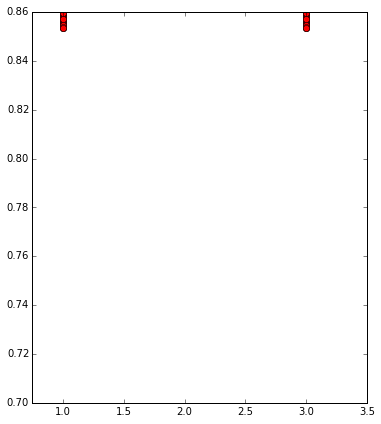

In [34]:
ngram_range = [r.parameters['count__ngram_range'] for r in tuning_results.grid_scores_]
plt.plot(ngram_range, scores, 'ro')
plt.axis([.75, 3.5, .7, .86])
plt.show()

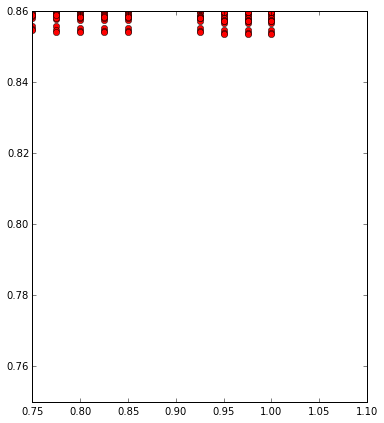

In [35]:
##max_df
max_df = [r.parameters['count__max_df'] for r in tuning_results.grid_scores_]
plt.plot(max_df, scores, 'ro')
plt.axis([.75, 1.1, .75, .86])
plt.show()

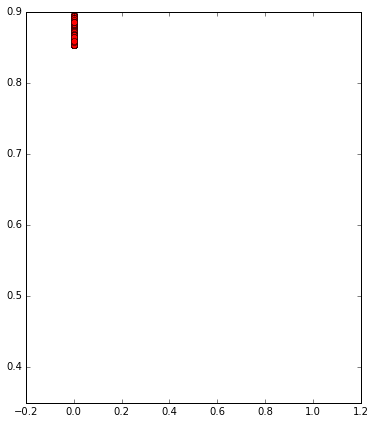

In [36]:
##min_df
s_words = [r.parameters['count__stop_words'] for r in tuning_results.grid_scores_]
for i in range(len(s_words)):
    if s_words[i] == None:      
        s_words[i] = 0
    else:
        s_words[i] = 1
plt.plot(s_words, scores, 'ro')
plt.axis([-.2, 1.2, .35, .9])
plt.show()

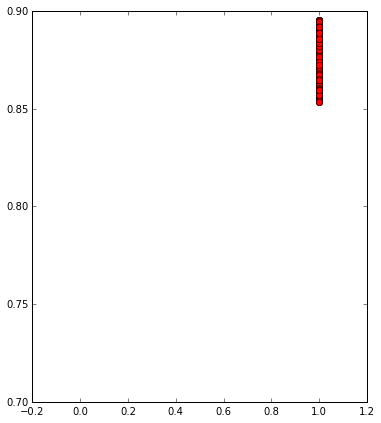

In [37]:
##Lowercase
case = [r.parameters['count__lowercase'] for r in tuning_results.grid_scores_]
for i in range(len(case)):
    if case[i] == False:      
        case[i] = 0
    else:
        case[i] = 1
plt.plot(case, scores, 'ro')
plt.axis([-.2, 1.2, .7, .9])
plt.show()

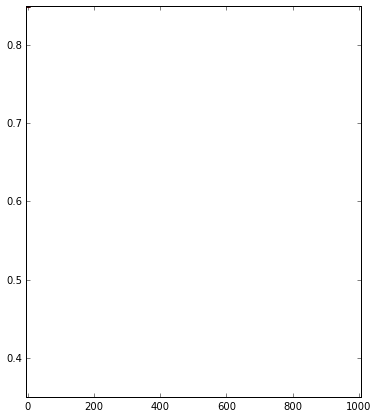

In [38]:
##Max Features
max_ft = [r.parameters['count__max_features'] for r in tuning_results.grid_scores_]
for i in range(len(max_ft)):
    if max_ft[i] == None: 
        max_ft[i] = 0

plt.plot(max_ft, scores, 'ro')
plt.axis([-5, 1005, .35, .85])
plt.show()

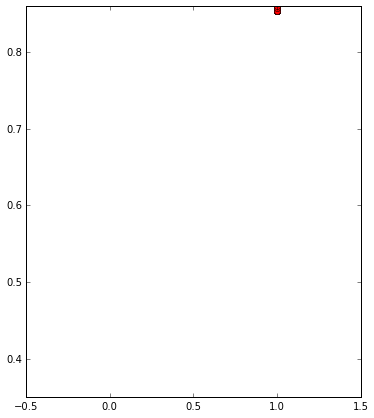

In [39]:
##Use_IDF
use_idf = [r.parameters['tfidf__use_idf'] for r in tuning_results.grid_scores_]
for i in range(len(use_idf)):
    if use_idf[i] == False: 
        use_idf[i] = 0
    else:
        use_idf[i] = 1

plt.plot(use_idf, scores, 'ro')
plt.axis([-.5, 1.5, .35, .86])
plt.show()

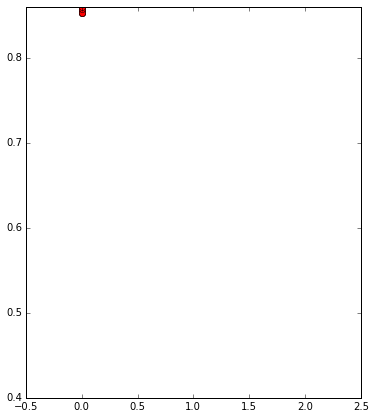

In [40]:
##Norm
norm = [r.parameters['tfidf__norm'] for r in tuning_results.grid_scores_]
for i in range(len(norm)):
    if norm[i] == None:      
        norm[i] = 0
    elif norm[i] == 'l1':
        norm[i] = 1
    else:
        norm[i] = 2
plt.plot(norm, scores, 'ro')
plt.axis([-.5, 2.5, .4, .86])
plt.show()

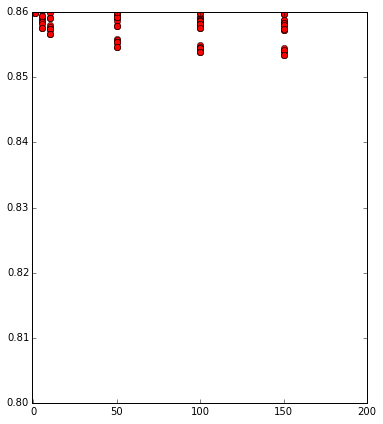

In [41]:
##C
c = [r.parameters['log__C'] for r in tuning_results.grid_scores_]
plt.plot(c, scores, 'ro')
plt.axis([-.5, 200, .8, .86])
plt.show()

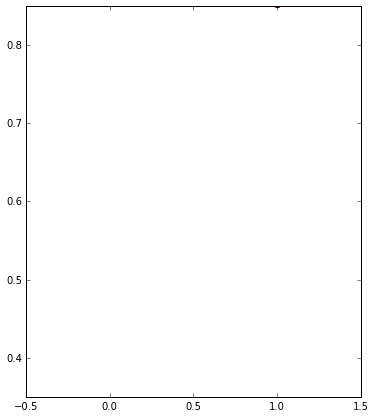

In [42]:
##Dual
dual = [r.parameters['log__dual'] for r in tuning_results.grid_scores_]
for i in range(len(dual)):
    if dual[i] == False: 
        dual[i] = 0
    else:
        dual[i] = 1

plt.plot(dual, scores, 'ro')
plt.axis([-.5, 1.5, .35, .85])
plt.show()

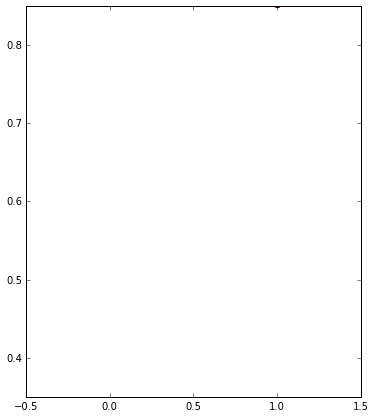

In [43]:
##Fit Intercept
f_int = [r.parameters['log__fit_intercept'] for r in tuning_results.grid_scores_]
for i in range(len(f_int)):
    if f_int[i] == False: 
        f_int[i] = 0
    else:
        f_int[i] = 1

plt.plot(f_int, scores, 'ro')
plt.axis([-.5, 1.5, .35, .85])
plt.show()

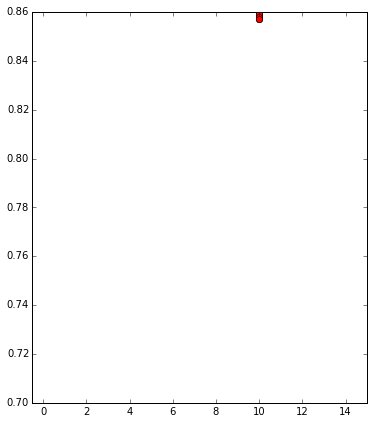

In [44]:
##Intercept Scaling
scaling = [r.parameters['log__intercept_scaling'] for r in tuning_results.grid_scores_]
plt.plot(scaling, scores, 'ro')
plt.axis([-.5, 15, .7, .86])
plt.show()

In [17]:
plt.rcParams['figure.figsize'] = (6,7)
topk = 3
ranked_results = sorted(tuning_results.grid_scores_, key=lambda x:x.mean_validation_score, reverse=True)
best_score = 1 ## 1 is highest
best_index = 0
best_params = None
for i, result in enumerate(ranked_results[:topk]):
    params = result.parameters
    pipeline.set_params(**params).fit(train_data['x'], train_data['y'])
    train_preds = pipeline.predict_proba(train_data['x'])
    test_preds = pipeline.predict_proba(test_data['x'])
    
    train_pred_arr = np.array(train_preds)
    train_preds_pos_column = train_pred_arr[:,1]
    
    test_pred_arr = np.array(test_preds)
    test_preds_pos_column = test_pred_arr[:,1]

    print "GRID SEARCH SCORE: %0.4f" % result.mean_validation_score
    print "TRAIN SCORE: %0.4f" % metrics.roc_auc_score(train_data['y'], train_preds_pos_column, average='micro')
    test_score = metrics.roc_auc_score(test_data['y'], test_preds_pos_column, average='micro')
    print "TEST SCORE: %0.4f" % test_score
    print params
    if test_score < best_score: 
        best_score=test_score
        best_index = i
        best_params = params
    print '*****************'

GRID SEARCH SCORE: 0.8954
TRAIN SCORE: 1.0000
TEST SCORE: 0.8878
{'count__stop_words': None, 'count__max_df': 0.95, 'log__penalty': 'l2', 'tfidf__norm': 'l2', 'log__random_state': 57, 'log__intercept_scaling': 0.01, 'log__C': 100, 'log__solver': 'liblinear', 'log__dual': True, 'tfidf__use_idf': True, 'count__ngram_range': (1, 3), 'log__fit_intercept': True, 'count__lowercase': True, 'count__max_features': None}
*****************


### Given the best test score, we can see what those parameters were, and save the model to a file if we want to use it later

In [18]:
best = ranked_results[best_index]
print "BEST TEST AUROC: %0.4f" % best_score
print "BEST MODEL PARAMS: %r" % best_params
model = pipeline.set_params(**best_params).fit(data['x'], data['y'])

BEST TEST AUROC: 0.8878
BEST MODEL PARAMS: {'count__stop_words': None, 'count__max_df': 0.95, 'log__penalty': 'l2', 'tfidf__norm': 'l2', 'log__random_state': 57, 'log__intercept_scaling': 0.01, 'log__C': 100, 'log__solver': 'liblinear', 'log__dual': True, 'tfidf__use_idf': True, 'count__ngram_range': (1, 3), 'log__fit_intercept': True, 'count__lowercase': True, 'count__max_features': None}


In [19]:
vocab = model.steps[0][1].vocabulary_
import operator
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(0))
print sorted_vocab

[(u'00', 0), (u'00 00', 1), (u'00 00 00', 2), (u'00 00 score', 3), (u'00 00 the', 4), (u'00 11', 5), (u'00 11 00', 6), (u'00 am', 7), (u'00 am was', 8), (u'00 and', 9), (u'00 and found', 10), (u'00 and the', 11), (u'00 and was', 12), (u'00 beer', 13), (u'00 beer and', 14), (u'00 for', 15), (u'00 for four', 16), (u'00 for fresh', 17), (u'00 for one', 18), (u'00 for party', 19), (u'00 for slice', 20), (u'00 hookah', 21), (u'00 hookah that', 22), (u'00 in', 23), (u'00 in the', 24), (u'00 of', 25), (u'00 of on', 26), (u'00 oysters', 27), (u'00 oysters buyer', 28), (u'00 oysters the', 29), (u'00 rotten', 30), (u'00 rotten tasting', 31), (u'00 score', 32), (u'00 score 38', 33), (u'00 sushi', 34), (u'00 sushi la', 35), (u'00 the', 36), (u'00 the prices', 37), (u'00 wine', 38), (u'00 wine 00', 39), (u'00 wish', 40), (u'00 wish seating', 41), (u'00am', 42), (u'00am needing', 43), (u'00am needing to', 44), (u'01', 45), (u'01 16', 46), (u'01 16 2013', 47), (u'01 2013', 48), (u'01 2013 34', 49), (

In [20]:
coefs = model.steps[2][1].coef_
coefs = coefs[0]
weighted_vocab = list()
for i in range(len(coefs)):
      weighted_vocab.append((coefs[i], sorted_vocab[i]))
weighted_vocab = sorted(weighted_vocab, key=operator.itemgetter(0), reverse=True)
for i in range(100):
    print weighted_vocab[i]

(11.787245032517976, (u'food poisoning', 77569))
(11.725342572399487, (u'poisoning', 165492))
(11.206140786063232, (u'food', 76692))
(9.7387242144904924, (u'got', 89409))
(6.4695751243851634, (u'got food', 89555))
(5.9099895335283392, (u'got food poisoning', 89558))
(5.8228003351419302, (u'after', 5715))
(5.5978694566915088, (u'39', 1887))
(5.1502488125817889, (u'from', 83116))
(5.0840721047576398, (u'got sick', 89785))
(4.9504869688068665, (u'diarrhea', 58004))
(4.9484850369674263, (u'had', 92307))
(4.2090331705506046, (u'34', 1422))
(4.1491686474860341, (u'later', 119074))
(4.1344881243273131, (u'bad', 26451))
(3.9887644853552113, (u'day', 55113))
(3.9672178015163881, (u'night', 140124))
(3.9097361561002053, (u'last', 118721))
(3.8098313463753986, (u'the food', 210063))
(3.727262341113625, (u'wife', 253665))
(3.7082818097344799, (u'stomach', 197435))
(3.5065825006211178, (u'ate', 24266))
(3.3823471407296033, (u'my wife', 137637))
(3.298607907727706, (u'days', 55518))
(3.2812074161618

In [21]:
with open('../data/Sick/sick_feature_weights.csv', 'wb') as f:
    c = csv.writer(f)
    for i in range(len(weighted_vocab)):
        c.writerow([weighted_vocab[i][0], weighted_vocab[i][1][0].encode('ascii', 'ignore')])

In [26]:
with open('../data/Sick/sick_test_preds.csv', 'wb') as f:
    c = csv.writer(f)
    for i in range(len(test_data['x'])):
        c.writerow([test_data['x'][i], test_preds_pos_column[i], test_data['y'][i]])

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, '../best_classifiers/sick_logreg_best.pkl') 